
# Simulating traffic on a cyclic road
The state of cellular automata is represented by a 1-dimensional array, the length of which represents the lenght of the road. The boundary condition is periodic, conceptually this means that we can think of the road as being a circle with cars going round and round. 

If there is not a car in a cell, the value of that cell is -1. Else, if there is a value in the range 0-max velocity (set to be 5 in both the Nagel and this paper) there is a car in the cell, with the value representing the speed of the car.

Running the cellular automata consists of two steps: (1) updating the velocities and (2) moving the cars.

1. The speed of each car is updated simulateously, given only the current state of all other cars. This means that cars do not take into account the current velocity of cars to estimate where they will be in the subsequent timestep (like a person is likely to do). There are 3 steps to updating the velocity of each car:
    1. If the car is travelling at less than max velocity, increase speed by 1.
    2. If the distance, defined as the number of empty cells between two cars plus 1, to the next car in front is smaller than or equal to the current velocity of the car, decrease the velocity to the distance-1.
    3. If the current speed is not 0, with some fixed probability, decrease the velocity by 1.
    
2. Each car is simultaneously advanced along the lane by the same number of cells as its velocity. E.g. if velocity is 2, move the car 2 cells forward.

By simultaneously, we mean that the first step is performed for every car before the second step is performed for any car. Taht is, all velocities are updated before any car is moved.

## Extending the model to multiple lanes
In the multiple lane model, the cellular automata is represented by a mxn array where m denotes the number of lanes and n the length of the road. In the edge case, a single lane road can be thought of a 1xn array.

To extend the model to multiple lanes, we now add a third step to running the cellular automata: updating the lanes of cars. This step will be performed before updating the velocities of cars and before moving them. Once it is completed, running the multiple lane cellular automata is equivalent to running several instances of the single-lane cellular automata defined previously. That is, for each lane, we perform simultaneous updates of velocity, then simultanous moving of the car. This means we only need to add a method for updating lanes.

If a car cannot accelerate––or in the case that it is already travelling at max velocity, maintain max velocity––in its current lane, it will see if it can do better in one of the adjacent lanes. That is, if the car can 1) accelerate––or in the case that it is already travelling at max velocity, maintain max velocity––and 2) fit without obstructing the car behind it in the new lane, it will swap. Specifically, we define a car to "fit" in a new lane if the distance to the next car behind it in the new lane is greater than 5. This definition is motivated by the assumption that cars are unable to infer the speed at which other cars are travelling. Consequently, the distance must be at least 5 to ensure that the car will not be hit by the one behind it, even if it is travelling at max velocity.

Thus, the procedure for the multilane model can be summarized as follows:

1. **Update Lanes**: 
2. **Update Velocity**:
3. **Move**:


# Future Work
Currently, there are approximately linear returns to adding lanes. That is, for every lane that we add, we can increase the number of additional cars that can be transported increases.
However, this is unlikely to be true in reality, due to on- and off-ramps. 

In [326]:
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt

class TrafficSimulation(object):
    
    def __init__(self, road_length, traffic_density, 
                 max_velocity, slowdown_proba, 
                 p_swap_lane = 1, n_lanes=2):
        
        assert type(max_velocity) is int, "Max_velocity must be an integer!"
        self.max_velocity = max_velocity
        
        assert type(road_length) is int, "Road length must be an integer!"
        self.road_length = road_length
        
        assert traffic_density >= 0 and traffic_density <=1, "Traffic density must be a proportion, 0<=x<=1"
        self.traffic_density = traffic_density
        
        assert slowdown_proba >= 0 and slowdown_proba <=1, "slowdown_proba must be a probability, 0<=x<=1"
        self.slowdown_proba = slowdown_proba
        
        assert p_swap_lane >= 0 and p_swap_lane <=1, "p_swap_lane must be a probability, 0<=x<=1"
        self.p_swap_lane = p_swap_lane
        
        assert type(n_lanes)==int, "Number of lanes must be an integer"
        self.n_lanes = n_lanes
        
        
        
        #Track number of cars that have passed the boundary
        self.flow = 0
        
        #Track number of timestep the simulation has been run
        self.time = 0
        
        #Number of cells to look back is equal to the maximum velocity
        self.look_back = max_velocity
        
        #Make road
        #Infer number of cars
        self.num_cars = np.round(road_length*traffic_density*n_lanes)
        num_cars = np.round(road_length*n_lanes*traffic_density)
        road_array = -np.ones((n_lanes, road_length), dtype=int)
        
        car_counter = 0
        #Insert the cars with 0 velocity at random positions on the road
        while car_counter < num_cars:
            random_loc = random.randrange(0, n_lanes), random.randrange(0, road_length)
            if road_array[random_loc] == -1:
                road_array[random_loc] = 0
                car_counter += 1
                
        self.road = road_array
        
    def look(self, lane, cell, ahead=True):
        '''
        Takes a current position, defined using lane and cell
        Returns distance to next car in direction ahead
        if ahead=False, returns distance to next car behind
        
        Distance is defined to be 0 if there is a car in same cell in other lane
        '''
        #If there is a car in the same cell in the other lane
        if self.road[lane, cell] == -1:
            return 0
            
        #1 if ahead
        if ahead:
            increment = 1
        else: 
            increment = -1
        
        distance = increment
        while self.road[lane, (cell + distance) % self.road_length] == -1:
            distance += increment
        
        return distance
        
    def can_accelerate(self, velocity, front_distance):
        '''
        Takes a speed and a distance to the next car in front,
        return a bool indicating if the car can speed up 
        (or in the case it is already at max_velocity, maintain its speed)
        '''
        
        #If already at max speed, see if you can maintain it in lane
        if velocity == self.max_velocity:
            if velocity >= front_distance:
                return False
        
        else: #see if you can speed up
            if velocity+1 >= front_distance:
                return False
        
        return True
    
    def check_lane(self, lane, cell, velocity):
        '''
        Checks if car, moved to road[lane, position] can:
        1) Accelerate
        2) Fit without obstructing car behind it
        '''
        
        #Look ahead, see if can accelerate
        front_distance = self.look(lane, cell)
        if not self.can_accelerate(velocity, front_distance):
            return False
        
        #Look back, see if there is space
        back_distance = self.look(lane, cell, ahead=False)
        #Back distance is negative, so we convert it to positive by *-1
        if -1*back_distance < self.max_velocity:
            return False
        
        return True
        
    def update_lanes(self):
        '''
        Updates the lane of each of the cars on the road,
        Starting from the top lane and working downwards
        '''
        if self.n_lanes == 1:
            return
        
        #Make an empty road to store updates on
        next_state = -np.ones((self.n_lanes, self.road_length), dtype=int)
        for lane in range(self.n_lanes):
            #For every cell in lane
            for cell in range(self.road_length):    
                
                #if cell is not a car, go to next cell
                if self.road[lane, cell] != -1:
                    
                    #Current speed of car
                    current_velocity = self.road[lane, cell]

                    #Get distance to car in front
                    distance = 1  # The number of empty cells between this car and the next plus 1
                    while self.road[lane, ((cell + distance) % self.road_length)] == -1:
                        distance += 1

                    #Flag for whether the car will look for lane swap
                    attempt_lane_swap = not self.can_accelerate(current_velocity, distance)
                    #print(attempt_lane_swap)
                    
                    #Try switching to lane above, else try lane down
                    if attempt_lane_swap:
                        

                        #If not already in the top lane, evaluate switching there
                        check_right = True
                        
                        if lane-1 >= 0:
                            if self.check_lane(lane-1, cell, current_velocity):
                                #print("I will can switch up")


                                #Swap possible to swap, swap with p=p_swap_lane
                                if random.random() <= self.p_swap_lane:
                                    next_state[lane-1, cell] = current_velocity
                                    check_right = False
                                
                                else:
                                    if not lane+1 <= self.n_lanes-1:
                                        next_state[lane, cell] = current_velocity
                            else:
                                if not lane+1 <= self.n_lanes-1:
                                    next_state[lane, cell] = current_velocity


                        #If not already in the bottom lane, evaluate switching there
                        #Same logic applies
                        if lane+1 <= self.n_lanes-1 and check_right:
                            if self.check_lane(lane+1, cell, current_velocity):

                                #Swap possible to swap, swap with p=p_swap_lane
                                if random.random() <= self.p_swap_lane:
                                    next_state[lane+1, cell] = current_velocity
                                else:
                                    next_state[lane, cell] = self.road[lane, cell]
                            else:
                                next_state[lane, cell] = self.road[lane, cell]
                        else:
                            next_state[lane, cell] = self.road[lane, cell]
                    else:
                        next_state[lane, cell] = self.road[lane, cell]

        
        #Update the lane of all cars simultaneously
        self.road = next_state
    
    
    def update_velocities(self):
        '''
        Updates velocity of each of the cars on the road
        '''
        
        for lane in range(self.n_lanes):
            #For every cell in lane
            for cell in range(self.road_length):
                
                #if cell is not a car, go to next cell
                if self.road[lane, cell] != -1:
                    

                    #Get distance to car in front
                    #distance = self.look(lane, cell
                    distance = 1  # The number of empty cells between this car and the next plus 1
                    while self.road[lane, ((cell + distance) % self.road_length)] == -1:
                        distance += 1

                    #Accelerate car by 1, if not already at max speed
                    if self.road[lane, cell] < self.max_velocity:
                        self.road[lane, cell] += 1

                    #Slow down due to other cars?
                    if self.road[lane, cell] >= distance:
                        self.road[lane, cell] = distance-1

                    #Random slowdown?
                    if random.random() <= self.slowdown_proba and  self.road[lane, cell]> 0:
                        self.road[lane, cell] -= 1
                    
        
    def step(self, track=False):
        '''
        Advances each car along its lane by its velocity
        '''
        if track:
            self.time += 1
        
        next_state = -np.ones((self.n_lanes, self.road_length), dtype=int)
        for lane in range(self.n_lanes):
            #For every cell in lane
            for cell in range(self.road_length):
                if self.road[lane, cell] != -1:
                    
                    #Check if car passes boundary
                    if track and (cell + self.road[lane, cell] > self.road_length-1):
                        self.flow += 1
                    
                    #next cell = current cell + current velocity, adjusting for periodic boundary
                    next_cell = (cell + self.road[lane, cell]) % self.road_length
                    next_state[lane, next_cell] = self.road[lane, cell]
                    
        self.road = next_state
                
    def display(self):
        plt.figure(figsize=(21, 2.5+(2.55*self.n_lanes)))
        sns.heatmap(np.where(self.road==-1, np.nan, self.road),
                        square=True, cmap="RdYlGn", vmin=0, vmax=self.max_velocity,
                        cbar=False, xticklabels=False, yticklabels=False,
                        alpha=.75, linewidths=0.75, linecolor="black")
        
    def display_basic(self):
        print(''.join('.' if x == -1 else str(x) for x in self.road[0]))

        
    def run(self, steps, warmup=0, display=False, track=True):
        '''
        Runs warmup laps without visualizing the results to get cars up to speed
        Then visualizes steps of the simulation
        '''
        
        #Warmup: Run warmup times without displaying state
        for step in range(warmup):

            #Update lanes, velocities and step
            self.update_lanes()
            self.update_velocities()
            self.step() #not tracking

        #Run simulation for # steps, displaying state after each
        for step in range(steps):
                
            #Update and step
            self.update_lanes()
            self.update_velocities()
            
            #Display state
            if display:
                self.display()
                
            self.step(track=track)

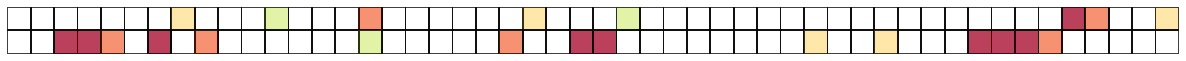

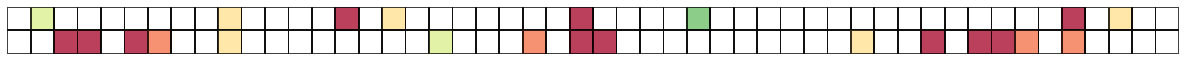

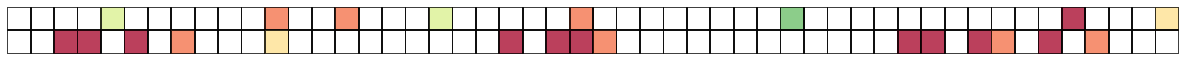

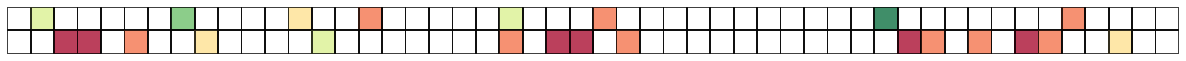

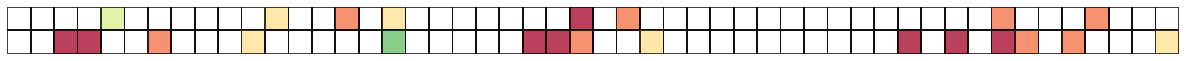

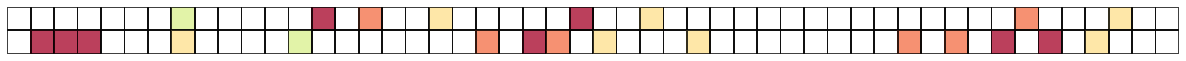

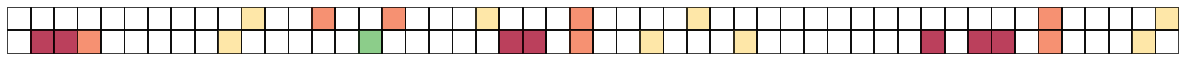

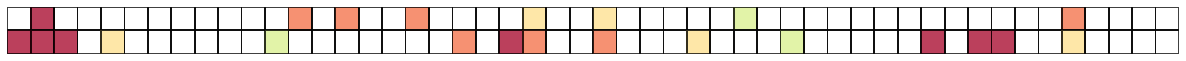

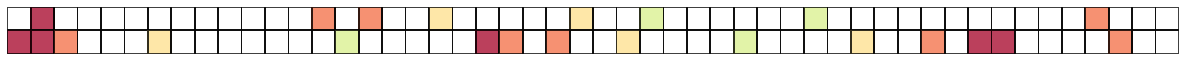

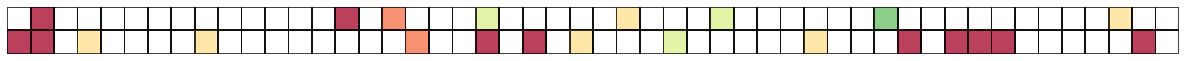

In [330]:
my_road=TrafficSimulation(50, 0.3, 5, 0.5, n_lanes=2)
my_road.run(10, 100, True)

In [264]:
def get_flow_data(simulations_per_density, steps_per_road, n_lanes=1):
    
    
    flow_rate_list = [[],[]] #for scatter plot
    mean_flow = [] #for plot
    lower_bound = [] 
    upper_bound = [] 
    
    density_list = [x/100 for x in range(1, 80, 1)]
    
    for density in density_list:
        #Intialize road with density
        temp_list = [] 

        for runs in range(simulations_per_density):
            #Run with 100 warmup, tracking post-warmup results
            my_road = TrafficSimulation(100, density, 5, 0.5, n_lanes=n_lanes)
            my_road.run(steps_per_road,100, False, True)
            
            
            #Store density and flow
            flow_rate_list[1].append(my_road.flow/my_road.time)
            flow_rate_list[0].append(density)
            
            #Store a temp list to use for computing percentile stats
            temp_list.append(my_road.flow/my_road.time)
            
        
        mean_flow.append(np.mean(temp_list))
        lower_bound.append(np.percentile(temp_list, 2.5))
        upper_bound.append(np.percentile(temp_list, 97.5))
    
    return flow_rate_list, mean_flow, upper_bound, lower_bound, density_list

In [265]:
flow_rate_list1, mean_flow1, upper_bound1, lower_bound1, density_list1 = \
        get_flow_data(25, 100, n_lanes=1)

In [328]:
flow_rate_list2, mean_flow2, upper_bound2, lower_bound2, density_list2 = \
        get_flow_data(25, 100, n_lanes=2)

In [334]:
def plot_flow(flow_rate_list, mean_flow, upper_bound, lower_bound, density_list, n_lanes):
    plt.figure(figsize=(12, 12))
    params = {'legend.fontsize': 'x-large',
              'figure.figsize': (15, 5),
             'axes.labelsize': 'xx-large',
             'axes.titlesize':'xx-large',
             'xtick.labelsize':'xx-large',
             'ytick.labelsize':'xx-large'}
    plt.rcParams.update(params)
    
    
    plt.scatter(flow_rate_list[0], flow_rate_list[1], linewidth=0.2)
    plt.plot(density_list, mean_flow, linewidth=5)
    plt.fill_between(density_list, upper_bound, lower_bound, alpha=0.3)
    plt.title("%s: Traffic Flow vs Traffic density"%n_lanes)
    plt.xlabel("Density [car per site]")
    plt.ylabel("Flow [car per timestep]")
    
    plt.show()

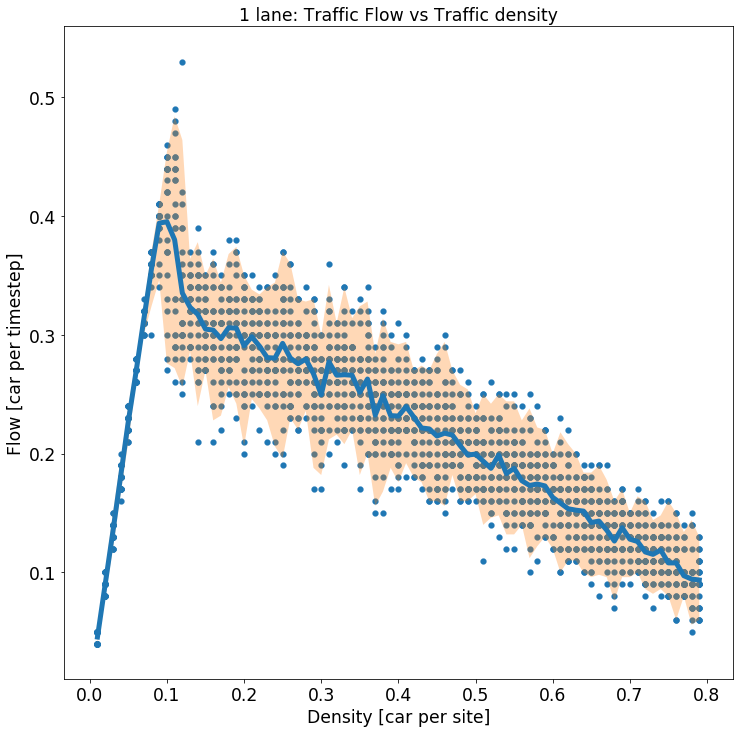

In [335]:
plot_flow(flow_rate_list1, mean_flow1, upper_bound1, lower_bound1, density_list1, "1 lane")

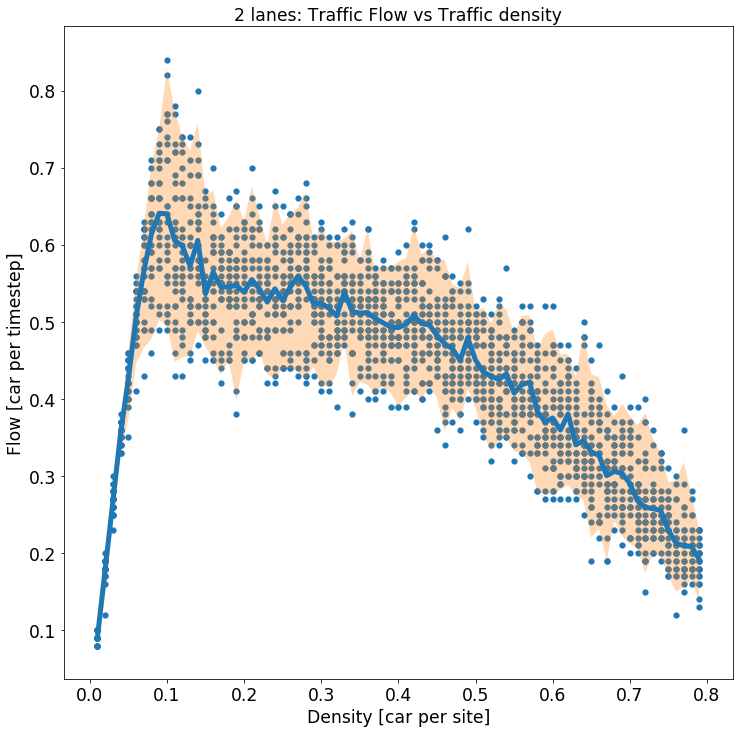

In [336]:
plot_flow(flow_rate_list2, mean_flow2, upper_bound2, lower_bound2, density_list2, "2 lanes")